# IMPORT IMPORTANT PACKAGES

In [97]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import cv2
import pathlib
import matplotlib as mpl

In [98]:
img_width = 448
img_height = 448
batch_size = 64
color = 3
dataset_folder = "date-fruit-image-dataset-in-controlled-environment"
dataset_url = 'https://www.kaggle.com/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment'
classes_name = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

#INSTALL DATASET USED IN OUR PROJECT

In [3]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download(dataset_url)

#SHOW DATASET IMAGES

In [5]:
dataset = pathlib.Path(dataset_folder)

In [6]:
def directory_dataset(dataset):
  folders = []
  for i in dataset.iterdir():
    if i.is_dir():
      folders.append(i)
  return folders   

In [7]:
folders = directory_dataset(dataset)

In [8]:
print(folders)

[PosixPath('date-fruit-image-dataset-in-controlled-environment/Galaxy'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Sokari'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Nabtat Ali'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Sugaey'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Ajwa'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Rutab'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Meneifi'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Shaishe'), PosixPath('date-fruit-image-dataset-in-controlled-environment/Medjool')]


In [9]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(dataset)))  

number of all images in dataset: 1658


In [10]:
def number_of_images_in_each_folder(folders):
  for i in folders:
    str_ = "{}: {}".format(i, len(list(pathlib.Path(i).glob("*.*"))))
    print(str_)

In [11]:
number_of_images_in_each_folder(folders)

date-fruit-image-dataset-in-controlled-environment/Galaxy: 190
date-fruit-image-dataset-in-controlled-environment/Sokari: 264
date-fruit-image-dataset-in-controlled-environment/Nabtat Ali: 177
date-fruit-image-dataset-in-controlled-environment/Sugaey: 168
date-fruit-image-dataset-in-controlled-environment/Ajwa: 175
date-fruit-image-dataset-in-controlled-environment/Rutab: 146
date-fruit-image-dataset-in-controlled-environment/Meneifi: 232
date-fruit-image-dataset-in-controlled-environment/Shaishe: 171
date-fruit-image-dataset-in-controlled-environment/Medjool: 135


date-fruit-image-dataset-in-controlled-environment/Galaxy/Galaxy Date (181).JPG


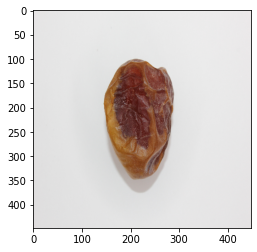

date-fruit-image-dataset-in-controlled-environment/Sokari/Sokari Date (264).JPG


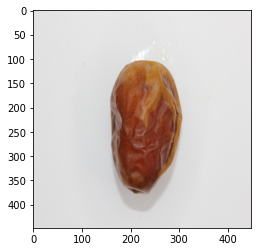

date-fruit-image-dataset-in-controlled-environment/Nabtat Ali/Nabtat Ali Date (156).JPG


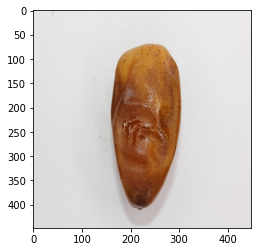

date-fruit-image-dataset-in-controlled-environment/Sugaey/Sugaey Date (164).JPG


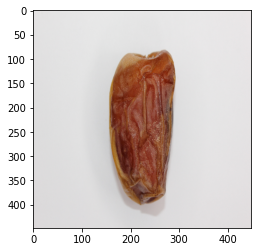

date-fruit-image-dataset-in-controlled-environment/Ajwa/Ajwa Date (124).JPG


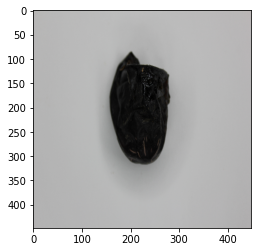

date-fruit-image-dataset-in-controlled-environment/Rutab/Rutab Date (75).JPG


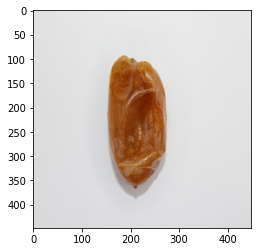

date-fruit-image-dataset-in-controlled-environment/Meneifi/Meneifi Date (194).JPG


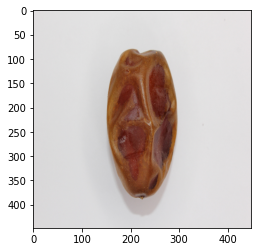

date-fruit-image-dataset-in-controlled-environment/Shaishe/Shaishe Date (31).JPG


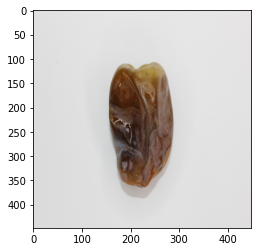

date-fruit-image-dataset-in-controlled-environment/Medjool/Medjool Date (67).JPG


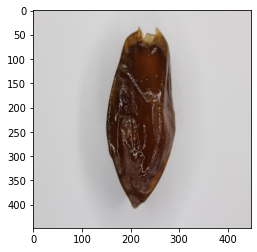

In [12]:
def show_single_image_in_each_directory(folders):
  for i in folders:
    images = list(pathlib.Path(i).glob("*.*"))
    print(images[0])
    img = cv2.imread(os.path.join(images[0]))
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
show_single_image_in_each_directory(folders)    

In [13]:
def Blurring(image):
  image = cv2.medianBlur(image,5)
  return image
def image_generator(dataset_folder):
  datagen = ImageDataGenerator( rescale=1/255, validation_split=0.1,vertical_flip=True ,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2,
                               rotation_range = 5, shear_range = 0.02,zoom_range = 0.02, preprocessing_function = Blurring)
  train_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training')
  validation_generator = datagen.flow_from_directory(
      dataset_folder, 
      target_size=(img_height, img_width),
      batch_size= batch_size,
      shuffle=False,
      class_mode='categorical',
      subset='validation') 
  return [train_generator, validation_generator]

In [14]:
[training_dataset, validation_dataset] = image_generator(dataset)

Found 1496 images belonging to 9 classes.
Found 162 images belonging to 9 classes.


In [24]:
def show_one_batch(data_generator):
    single_batch = data_generator.next() 
    images = single_batch[0] 
    labels = single_batch[1] 
    for i in range(batch_size):
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.show() 

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


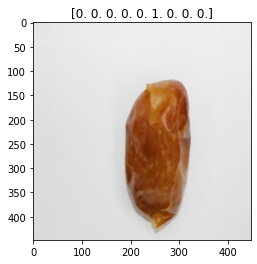

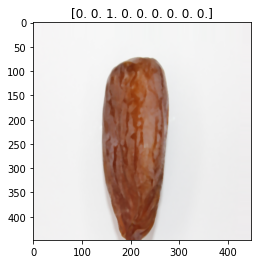

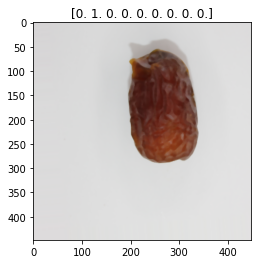

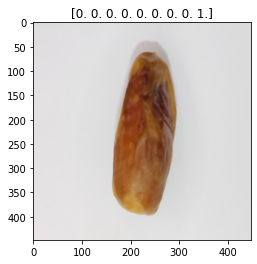

In [ ]:
show_one_batch(training_dataset)

#Transfer Learning using mobilenet_v2

In [26]:
mo = keras.applications.mobilenet_v2
conv_model = mo.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, color))
the_model = keras.layers.Dropout(0.2)(conv_model.output)
the_model = keras.layers.Flatten()(the_model)
the_model = keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
the_model = keras.layers.Dropout(0.2)(the_model)
the_model = keras.layers.Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
the_model = keras.layers.Dropout(0.2)(the_model)
the_model = keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
the_model = keras.layers.Dropout(0.2)(the_model)
the_model = keras.layers.Dense(32, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
the_model = keras.layers.Dropout(0.2)(the_model)
the_model = keras.layers.Dense(16, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
the_model = keras.layers.Dropout(0.2)(the_model)
predictions = keras.layers.Dense(len(classes_name), activation='softmax', activity_regularizer=tf.keras.regularizers.L2(0.01))(the_model)
mo = keras.models.Model(inputs=conv_model.input, outputs=predictions)
for layer in mo.layers[:151]:
    layer.trainable = False
for layer in mo.layers[151:]:
    layer.trainable = True
mo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 224, 224, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [27]:
len(mo.layers)

167

In [28]:
mo.layers[151:]

In [29]:
me = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [30]:
base_learning_rate = 0.01
mo.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=me)

In [31]:
call_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
callbacks = [call_1]

In [32]:
epochs=300
history = mo.fit(
  training_dataset,
  epochs=epochs,
  callbacks = callbacks,
  batch_size = batch_size
)

Epoch 1/300
24/24 [==============================] - 267s 11s/step - loss: 129.3401 - tp: 42.0000 - fp: 373.0000 - tn: 11595.0000 - fn: 1454.0000 - accuracy: 0.8643 - precision: 0.1012 - recall: 0.0281 - auc: 0.5009
Epoch 2/300
24/24 [==============================] - 267s 11s/step - loss: 65.0512 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5340
Epoch 3/300
24/24 [==============================] - 259s 11s/step - loss: 30.6936 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5468
Epoch 4/300
24/24 [==============================] - 259s 11s/step - loss: 17.5129 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5518
Epoch 5/300
24/24 [==============================] - 258s 11s/step - loss: 11.5990 - tp: 0.0000e+00 

# Metrics

In [74]:
def drawing(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.rcParams["figure.figsize"] = (20,4)
  mpl.style.use('seaborn')
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

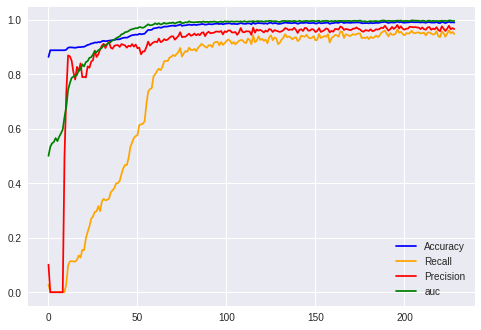

In [77]:
drawing(
    [history.history['accuracy'], 'Accuracy'],
    [history.history['recall'], 'Recall'],
    [history.history['precision'], 'Precision'],
    [history.history['auc'], 'auc']
)

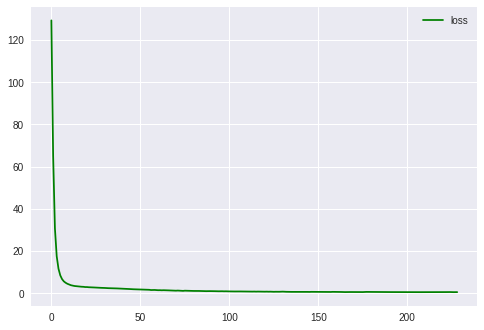

In [78]:
plt.plot(history.history['loss'],'green', label="loss")
plt.legend()

In [37]:
mo.evaluate(validation_dataset,batch_size = validation_dataset.batch_size ,steps = validation_dataset.n // validation_dataset.batch_size)

2/2 [==============================] - 24s 10s/step - loss: 0.5501 - tp: 122.0000 - fp: 6.0000 - tn: 1018.0000 - fn: 6.0000 - accuracy: 0.9896 - precision: 0.9531 - recall: 0.9531 - auc: 0.9901


[0.55009925365448,
 122.0,
 6.0,
 1018.0,
 6.0,
 0.9895833730697632,
 0.953125,
 0.953125,
 0.99005126953125]

In [79]:
validation_dataset.reset()

In [81]:
Y_pred = mo.predict(validation_dataset,  workers=1)

In [82]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [99]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 7, 1,
       1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 8, 5, 5, 5, 5, 8, 3, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8])

In [91]:
validation_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [84]:
len(y_pred)

162

In [85]:
len(validation_dataset.classes)

162

In [86]:
res = tf.math.confusion_matrix(y_pred,validation_dataset.classes).numpy()

In [87]:
confusion_matrix = pd.DataFrame(res,
                     index = classes_name, 
                     columns = classes_name)

In [88]:
confusion_matrix

,Ajwa,Galaxy,Medjool,Meneifi,Nabtat Ali,Rutab,Shaishe,Sokari,Sugaey
Ajwa,17,0,0,0,0,0,0,0,0
Galaxy,0,17,0,1,0,0,0,1,0
Medjool,0,0,13,2,0,0,0,0,0
Meneifi,0,0,0,20,0,1,1,0,0
Nabtat Ali,0,0,0,0,17,0,0,0,0
Rutab,0,0,0,0,0,11,0,0,0
Shaishe,0,0,0,0,0,0,16,0,0
Sokari,0,2,0,0,0,0,0,25,0
Sugaey,0,0,0,0,0,2,0,0,16


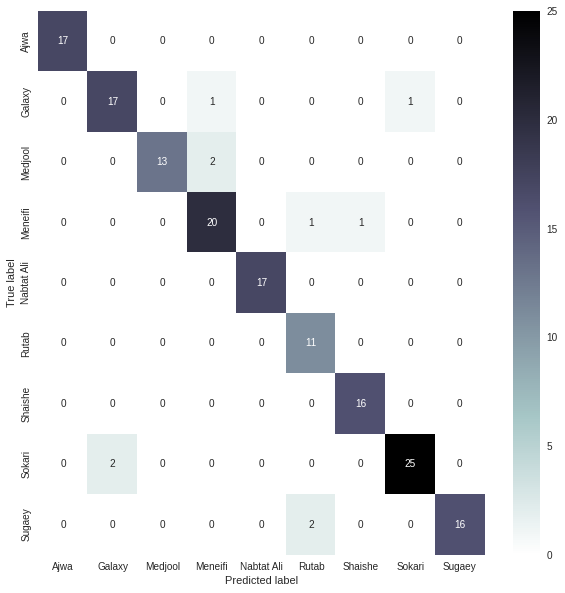

In [96]:
import seaborn as sns
mpl.style.use('seaborn')
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.bone_r)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [94]:
classifi_report = classification_report(validation_dataset.classes, y_pred,target_names = classes_name)
print(classifi_report)

              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        17
      Galaxy       0.89      0.89      0.89        19
     Medjool       0.87      1.00      0.93        13
     Meneifi       0.91      0.87      0.89        23
  Nabtat Ali       1.00      1.00      1.00        17
       Rutab       1.00      0.79      0.88        14
     Shaishe       1.00      0.94      0.97        17
      Sokari       0.93      0.96      0.94        26
      Sugaey       0.89      1.00      0.94        16

    accuracy                           0.94       162
   macro avg       0.94      0.94      0.94       162
weighted avg       0.94      0.94      0.94       162

